<a href="https://colab.research.google.com/github/dsogden/Quantitative_Finance/blob/main/Danges_of_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
from scipy import poly1d
import yfinance as yf

## Example: Curve Fitting

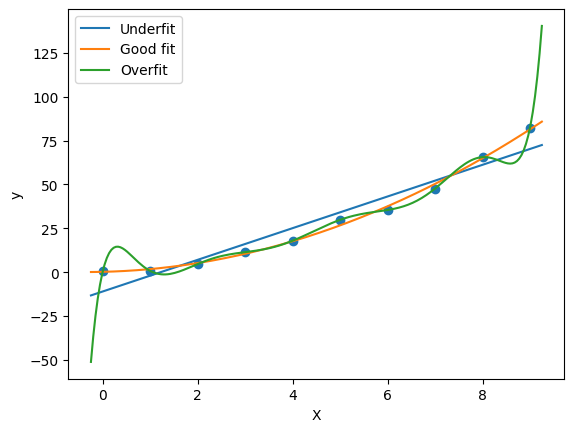

In [2]:
x = np.arange(10)
y = 2 * np.random.randn(10) + x ** 2
xs = np.linspace(-0.25, 9.25, 200)

lin = np.polyfit(x, y, 1)
quad = np.polyfit(x, y, 2)
many = np.polyfit(x, y, 9)

plt.scatter(x, y)
plt.plot(xs, poly1d(lin)(xs), label='Underfit')
plt.plot(xs, poly1d(quad)(xs), label='Good fit')
plt.plot(xs, poly1d(many)(xs), label='Overfit')
plt.ylabel('y')
plt.xlabel('X')
plt.legend()
plt.show()

## Example: Regression Parameters

In [3]:
start = '2013-01-01'
end = '2014-01-01'

x1 = yf.download('PEP', start=start, end=end)['Close']
x2 = yf.download('MCD', start=start, end=end)['Close']
x3 = yf.download('DJI', start=start, end=end)['Close']
y = yf.download('PG', start=start, end=end)['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
slr = regression.linear_model.OLS(y, sm.add_constant(x1)).fit()
B0, B1 = slr.params
slr_prediction = B0 + x1 * B1

X = np.column_stack((x1, x2, x3))
mlr = regression.linear_model.OLS(y, sm.add_constant(X)).fit()
B0, B1, B2, B3 = mlr.params
mlr_prediction = B0 + B1 * x1 + B2 * x2 + B3 * x3

print(f'SLR R2: {slr.rsquared_adj}')
print(f'SLR P-Value: {slr.f_pvalue}')
print(f'MLR R2: {mlr.rsquared_adj}')
print(f'MLR P-Value: {mlr.f_pvalue}')

SLR R2: 0.7210958409881614
SLR P-Value: 1.7286386512868075e-71
MLR R2: 0.7922511827073275
MLR P-Value: 6.00182225985899e-85


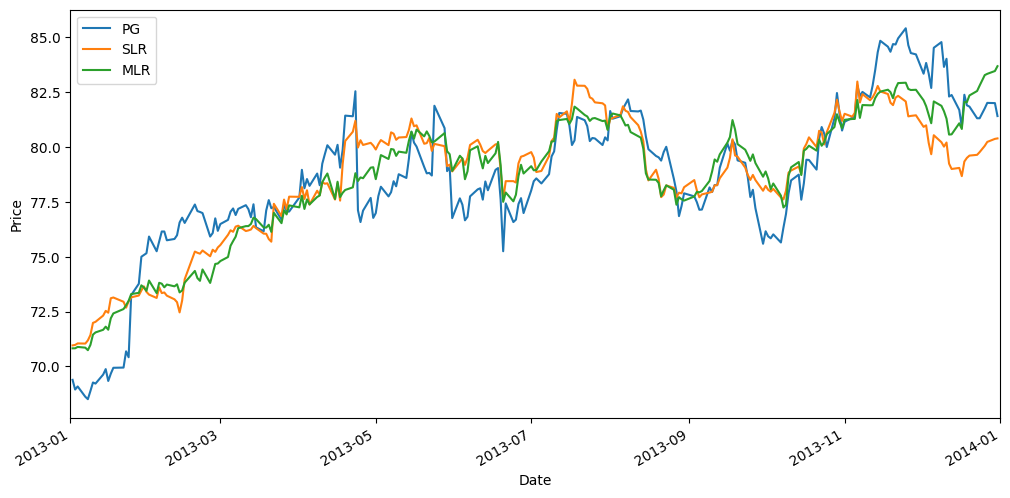

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y.index, y.values)
slr_prediction.plot(ax=ax)
mlr_prediction.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_xlim(['2013-01', '2014-01'])
plt.legend(['PG', 'SLR', 'MLR'])
plt.show()

In [6]:
start = '2014-01-01'
end = '2015-01-01'

x1 = yf.download('PEP', start=start, end=end)['Close']
x2 = yf.download('MCD', start=start, end=end)['Close']
x3 = yf.download('DJI', start=start, end=end)['Close']
y = yf.download('PG', start=start, end=end)['Close']

slr_prediction2 = slr.params[0] + slr.params[1] * x1
mlr_prediction2 = mlr.params[0] + mlr.params[1] * x1 + mlr.params[2] * x2 + mlr.params[3] * x3

p = 1
N = len(y)
adj1 = float(N - 1) / (N - p - 1)

p = 3
N = len(y)
adj2 = float(N - 1) / (N - p - 1)


SST = sum((y - np.mean(y))**2)
SSRs = sum((slr_prediction2 - y)**2)
print('\nSLR R-squared:', 1 - adj1*SSRs/SST)
SSRm = sum((mlr_prediction2 - y)**2)
print('MLR R-squared:', 1 - adj2*SSRm/SST)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


SLR R-squared: 0.42756302840476756
MLR R-squared: 0.09212724561035568


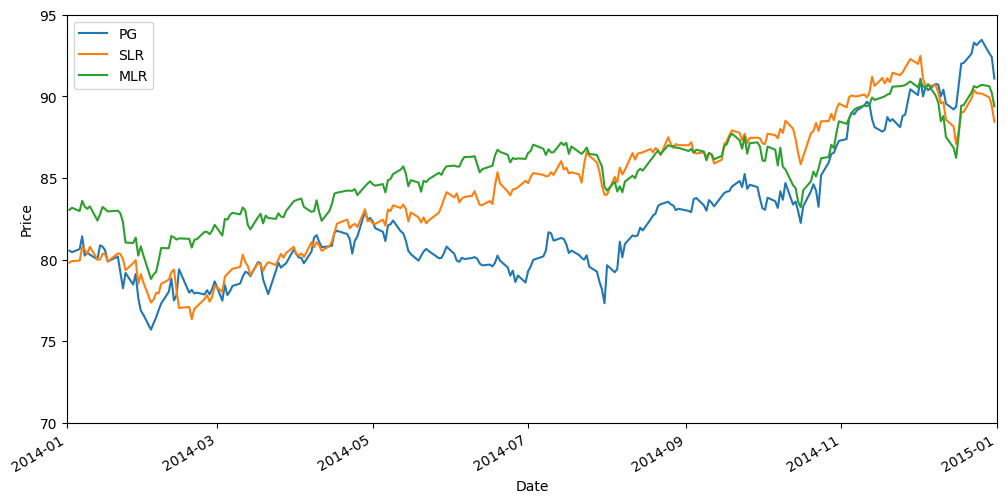

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(y.index, y.values)
slr_prediction2.plot(ax=ax)
mlr_prediction2.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_xlim(['2014-01', '2015-01'])
ax.set_ylim([70, 95])
plt.legend(['PG', 'SLR', 'MLR'])
plt.show()

In [8]:
start = '2011-01-01'
end = '2013-01-01'
pricing = yf.download('MCD', start=start, end=end)['Close']

mu_30d = pricing.rolling(window=30).mean()
mu_60d = pricing.rolling(window=60).mean()
mu_100d = pricing.rolling(window=100).mean()

[*********************100%%**********************]  1 of 1 completed


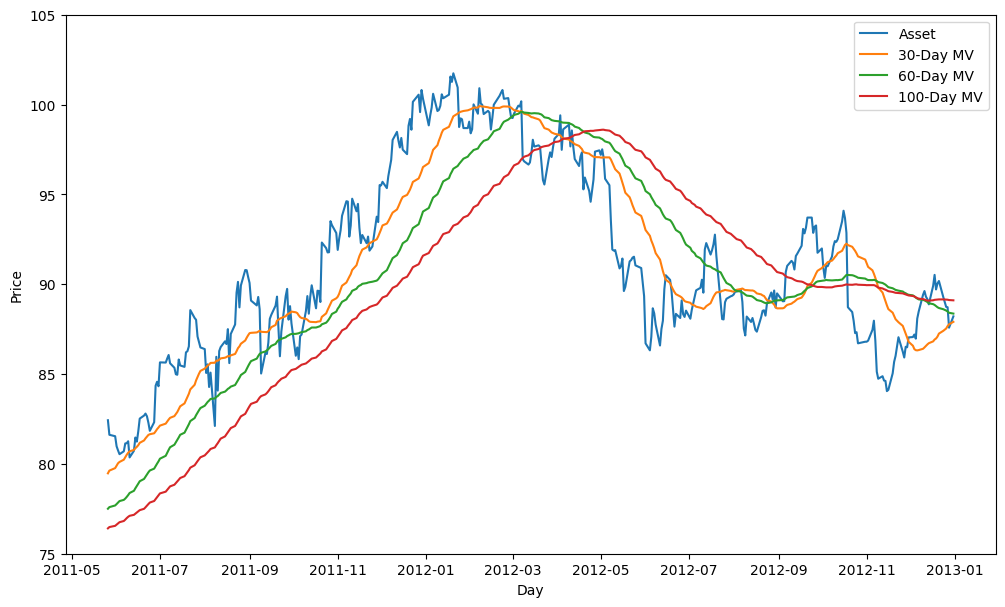

In [9]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(pricing[100:], label='Asset')
ax.plot(mu_30d[100:], label='30-Day MV')
ax.plot(mu_60d[100:], label='60-Day MV')
ax.plot(mu_100d[100:], label='100-Day MV')
ax.set_ylim([75, 105])
ax.set_xlabel('Day')
ax.set_ylabel('Price')
ax.legend()
plt.show()

In [10]:
def trade(stock, length):
    if length == 0:
        return 0

    rolling_window = stock.rolling(window=length)
    mu, std = rolling_window.mean(), rolling_window.std()

    zscores = (stock - mu) / std

    # Simulation
    money = 0
    count = 0
    for i in range(len(stock)):
        if zscores[i] > 1:
            money += stock[i]
            count -= 1
        elif zscores[i] < -1:
            money -= stock[i]
            count += 1
        elif np.abs(zscores[i]) < 0.5:
            money += count * stock[i]
            count = 0
    return money

In [11]:
length_scores = [trade(pricing, l) for l in range(255)]
best_length = np.argmax(length_scores)
print(f'Best window: {best_length}')

Best window: 11


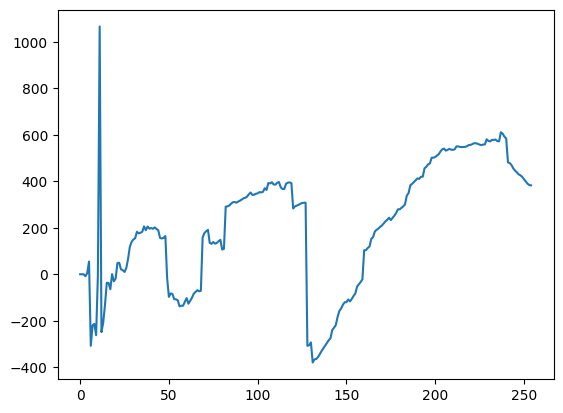

In [12]:
plt.plot(length_scores)
plt.show()

In [16]:
start2 = '2013-01-01'
end2 = '2015-01-01'

pricing2 = yf.download('MCD', start=start2, end=end2)['Close']
length_scores2 = [trade(pricing2, l) for l in range(255)]
print(f'Best length {best_length} (day window): {length_scores[best_length]}')
best_length2 = np.argmax(length_scores2)
print(f'Best length {best_length2} (day window): {length_scores2[best_length2]}')

[*********************100%%**********************]  1 of 1 completed


Best length 11 (day window): 1065.8799896240234
Best length 189 (day window): 471.2797088623047


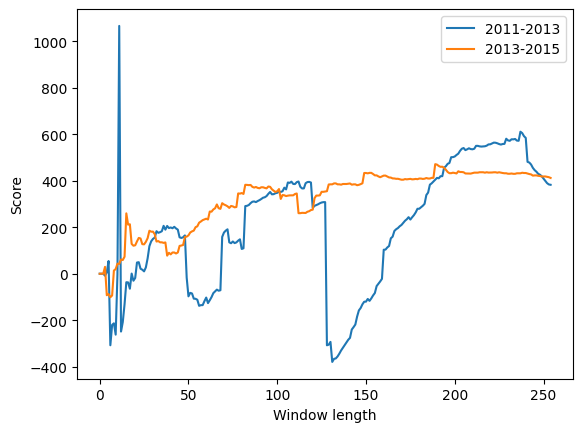

In [17]:
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['2011-2013', '2013-2015'])
plt.show()